Изменение сверточной сети на Resnet152. 

Увеличение выходных нейронов до 6.

Использование нового оптимизатора AdamW

Увеличение эпох до 40 штук.

Достигнутый результат 0.91666

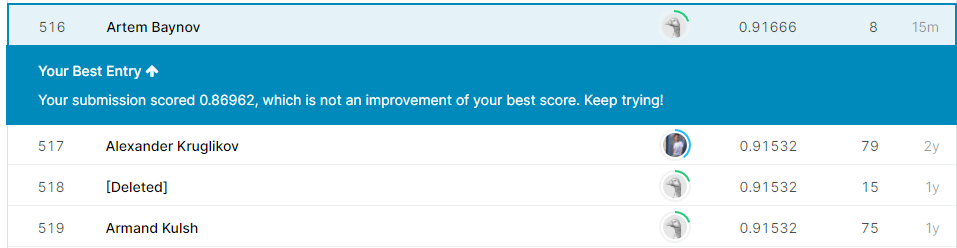

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('./plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('./kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("./kaggle/working/"))

['.config', 'submission.csv', 'drive', 'plates.zip', 'sample_data']
After zip extraction:
['plates']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_root = './kaggle/working/plates/'
print(os.listdir(data_root))

['train', 'test']


In [ ]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 2453.31it/s]


In [ ]:
!ls train

cleaned  dirty


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(train_dataloader), len(train_dataset)

(8, 32)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


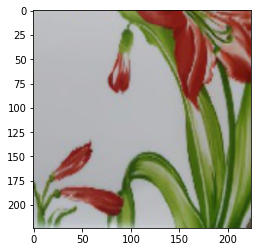

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


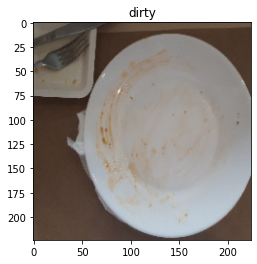

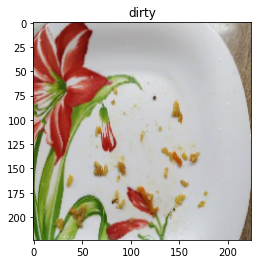

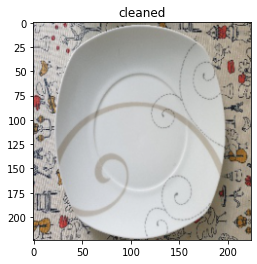

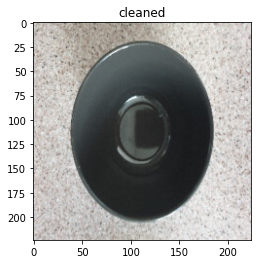

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
#model = models.resnet18(pretrained=True)
model = models.resnet152(pretrained=True)
#model = models.resnet50(pretrained=True)
#model = models.resnet34(pretrained=True)
#model = models.resnet101(pretrained=True)


# Disable grad for all conv layers
for param in model.parameters():
   param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 6)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
#resnet101
#optimizer = torch.optim.Adamax(model.parameters(), lr=1.0e-3) #0.74
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0) #0.86
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) #0.73
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False) #0.82
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #0.83

#resnet34
#optimizer = torch.optim.Adamax(model.parameters(), lr=1.0e-3) #0.7
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0) #0.64
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) #0.8
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False) #0.72
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #0.65

#resnet50
#optimizer = torch.optim.Adamax(model.parameters(), lr=1.0e-3) #0.85
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0) #0.85
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) #0.87
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False) #0.78
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #0.73

#resnet152
#optimizer = torch.optim.Adamax(model.parameters(), lr=1.0e-3) #0.54
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0) #0.82
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) #0.86
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False) #0.9
#optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001) #0.83
# Decay LR by a factor of 0.1 every 7 epochs


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0,39], gamma=0.1, last_epoch=-1, verbose=False)




In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=40);

Epoch 0/39:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slown

train Loss: 1.0098 Acc: 0.3750



100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

val Loss: 0.6025 Acc: 0.7500
Epoch 1/39:



100%|██████████| 8/8 [00:01<00:00,  6.64it/s]

train Loss: 0.6009 Acc: 0.7500



100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

val Loss: 0.5814 Acc: 0.7500
Epoch 2/39:



100%|██████████| 8/8 [00:01<00:00,  6.55it/s]

train Loss: 0.5150 Acc: 0.7812



100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

val Loss: 0.5480 Acc: 0.7500
Epoch 3/39:



100%|██████████| 8/8 [00:01<00:00,  6.69it/s]

train Loss: 0.5262 Acc: 0.7500



100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

val Loss: 0.6065 Acc: 0.7500
Epoch 4/39:



100%|██████████| 8/8 [00:01<00:00,  6.78it/s]

train Loss: 0.5471 Acc: 0.7188



100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

val Loss: 0.5785 Acc: 0.7500
Epoch 5/39:



100%|██████████| 8/8 [00:01<00:00,  6.97it/s]

train Loss: 0.5218 Acc: 0.7500



100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

val Loss: 0.5967 Acc: 0.6250
Epoch 6/39:



100%|██████████| 8/8 [00:01<00:00,  6.73it/s]

train Loss: 0.3421 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

val Loss: 0.5717 Acc: 0.6250
Epoch 7/39:



100%|██████████| 8/8 [00:01<00:00,  6.95it/s]

train Loss: 0.3049 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

val Loss: 0.5762 Acc: 0.6250
Epoch 8/39:



100%|██████████| 8/8 [00:01<00:00,  6.56it/s]

train Loss: 0.3571 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

val Loss: 0.5511 Acc: 0.6250
Epoch 9/39:



100%|██████████| 8/8 [00:01<00:00,  6.94it/s]

train Loss: 0.4317 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

val Loss: 0.5533 Acc: 0.6250
Epoch 10/39:



100%|██████████| 8/8 [00:01<00:00,  6.60it/s]

train Loss: 0.3887 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

val Loss: 0.5609 Acc: 0.6250
Epoch 11/39:



100%|██████████| 8/8 [00:01<00:00,  6.61it/s]

train Loss: 0.3790 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

val Loss: 0.5881 Acc: 0.6250
Epoch 12/39:



100%|██████████| 8/8 [00:01<00:00,  6.96it/s]

train Loss: 0.3925 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

val Loss: 0.5970 Acc: 0.7500
Epoch 13/39:



100%|██████████| 8/8 [00:01<00:00,  6.68it/s]

train Loss: 0.4583 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

val Loss: 0.5844 Acc: 0.7500
Epoch 14/39:



100%|██████████| 8/8 [00:01<00:00,  6.81it/s]

train Loss: 0.4369 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

val Loss: 0.6019 Acc: 0.6250
Epoch 15/39:



100%|██████████| 8/8 [00:01<00:00,  6.90it/s]

train Loss: 0.3174 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

val Loss: 0.5869 Acc: 0.7500
Epoch 16/39:



100%|██████████| 8/8 [00:01<00:00,  6.71it/s]

train Loss: 0.3292 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

val Loss: 0.5853 Acc: 0.6250
Epoch 17/39:



100%|██████████| 8/8 [00:01<00:00,  6.55it/s]

train Loss: 0.2978 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

val Loss: 0.5770 Acc: 0.6250
Epoch 18/39:



100%|██████████| 8/8 [00:01<00:00,  6.66it/s]

train Loss: 0.3759 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

val Loss: 0.5809 Acc: 0.6250
Epoch 19/39:



100%|██████████| 8/8 [00:01<00:00,  6.53it/s]

train Loss: 0.2899 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

val Loss: 0.5782 Acc: 0.7500
Epoch 20/39:



100%|██████████| 8/8 [00:01<00:00,  6.61it/s]

train Loss: 0.3920 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

val Loss: 0.5768 Acc: 0.6250
Epoch 21/39:



100%|██████████| 8/8 [00:01<00:00,  6.80it/s]

train Loss: 0.3591 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

val Loss: 0.5900 Acc: 0.6250
Epoch 22/39:



100%|██████████| 8/8 [00:01<00:00,  6.73it/s]

train Loss: 0.3173 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

val Loss: 0.5800 Acc: 0.6250
Epoch 23/39:



100%|██████████| 8/8 [00:01<00:00,  6.59it/s]

train Loss: 0.4230 Acc: 0.7812



100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

val Loss: 0.5680 Acc: 0.7500
Epoch 24/39:



100%|██████████| 8/8 [00:01<00:00,  6.68it/s]

train Loss: 0.3518 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

val Loss: 0.5866 Acc: 0.7500
Epoch 25/39:



100%|██████████| 8/8 [00:01<00:00,  6.67it/s]

train Loss: 0.4042 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

val Loss: 0.5997 Acc: 0.7500
Epoch 26/39:



100%|██████████| 8/8 [00:01<00:00,  6.73it/s]

train Loss: 0.3548 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

val Loss: 0.5759 Acc: 0.7500
Epoch 27/39:



100%|██████████| 8/8 [00:01<00:00,  6.49it/s]

train Loss: 0.3486 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

val Loss: 0.6026 Acc: 0.7500
Epoch 28/39:



100%|██████████| 8/8 [00:01<00:00,  6.69it/s]

train Loss: 0.2944 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

val Loss: 0.6064 Acc: 0.6250
Epoch 29/39:



100%|██████████| 8/8 [00:01<00:00,  6.71it/s]

train Loss: 0.3933 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

val Loss: 0.5753 Acc: 0.7500
Epoch 30/39:



100%|██████████| 8/8 [00:01<00:00,  6.68it/s]

train Loss: 0.3420 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

val Loss: 0.5776 Acc: 0.6250
Epoch 31/39:



100%|██████████| 8/8 [00:01<00:00,  6.70it/s]

train Loss: 0.4030 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

val Loss: 0.5880 Acc: 0.7500
Epoch 32/39:



100%|██████████| 8/8 [00:01<00:00,  6.66it/s]

train Loss: 0.4034 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

val Loss: 0.5824 Acc: 0.7500
Epoch 33/39:



100%|██████████| 8/8 [00:01<00:00,  6.67it/s]

train Loss: 0.3246 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

val Loss: 0.6032 Acc: 0.7500
Epoch 34/39:



100%|██████████| 8/8 [00:01<00:00,  7.00it/s]

train Loss: 0.3556 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

val Loss: 0.5712 Acc: 0.6250
Epoch 35/39:



100%|██████████| 8/8 [00:01<00:00,  6.56it/s]


train Loss: 0.3278 Acc: 0.8438


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

val Loss: 0.5978 Acc: 0.6250
Epoch 36/39:



100%|██████████| 8/8 [00:01<00:00,  6.52it/s]

train Loss: 0.3704 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

val Loss: 0.6001 Acc: 0.6250
Epoch 37/39:



100%|██████████| 8/8 [00:01<00:00,  6.74it/s]

train Loss: 0.3297 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

val Loss: 0.5792 Acc: 0.6250
Epoch 38/39:



100%|██████████| 8/8 [00:01<00:00,  6.75it/s]

train Loss: 0.4076 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

val Loss: 0.5690 Acc: 0.6250
Epoch 39/39:



100%|██████████| 8/8 [00:01<00:00,  6.65it/s]

train Loss: 0.3855 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

val Loss: 0.5650 Acc: 0.6250


In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/content/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /content/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 186/186 [00:21<00:00,  8.82it/s]


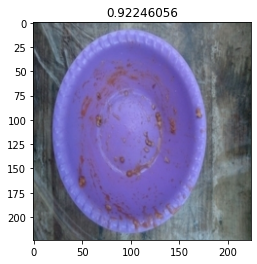

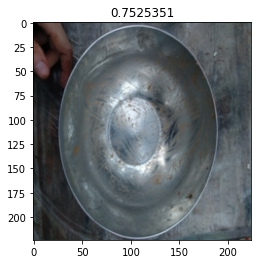

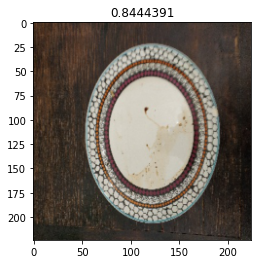

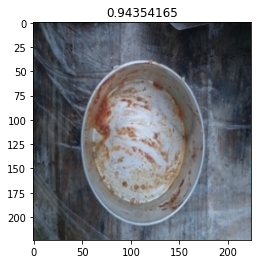

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test kaggle